In [1]:
from utils.model import PointNetClassification

import torch
import torch.nn as nn
import os
import numpy as np

## Data loader

In [2]:
input_dir = 'DATA/MicroActivity3D'
files = os.listdir(input_dir)

In [3]:
# #行動にラベルを付与
# from collections import defaultdict

# label_dict = dict()
# label_num = defaultdict(int)
# class_set = set()
# num_class = 0

# for file in files:
#     action = file[1:3]
#     microactivity = action
#     label_num[microactivity]+=1
#     if microactivity not in class_set:
#         label_dict[microactivity] = num_class
#         num_class+=1
#         class_set.add(microactivity)
# print(label_dict)
# print(label_num)

In [4]:
#マイクロ行動にラベルを付与
from collections import defaultdict

label_dict = dict()
label_num = defaultdict(int)
class_set = set()
num_class = 0

for file in files:
    action = file[1:3]
    obj = file[5:7]
    microactivity = action + obj
    label_num[microactivity]+=1
    if microactivity not in class_set:
        label_dict[microactivity] = num_class
        num_class+=1
        class_set.add(microactivity)
print(label_dict)
print(label_num)

{'0302': 0, '0102': 1, '0301': 2, '0101': 3, '0303': 4, '0103': 5}
defaultdict(<class 'int'>, {'0302': 42, '0102': 42, '0301': 38, '0101': 38, '0303': 25, '0103': 18})


In [5]:
import torch.utils.data as data

class PointCloudDataset(data.Dataset):

    def __init__(self,target_files,phase,transform,class_label):
        self.transform=transform
        self.class_label = class_label
        self.target_files=target_files

    def __len__(self):
        return len(self.target_files)

    def __getitem__(self,index):
        pcd,one_hot = self.pull_item(index)
        return pcd,one_hot

    def pull_item(self,index):
        self.path=self.target_files[index]

        #label
        label = int(self.class_label[self.path[1:3]+ self.path[5:7]]) # 

        #load_pcd
        pcd = np.load('DATA/MicroActivity3D/' + self.path, allow_pickle=True)['arr_0']
        pcd = torch.from_numpy(pcd.astype(np.float32)).clone()
        pcd = torch.nn.functional.normalize(pcd, p=2.0, dim=0, eps=1e-12)
        #pcd=self.transform(pcd)
        return pcd, label

In [6]:
n_samples = len(files)
train_num = int(n_samples * 0.7)
val_num = int(n_samples * 0.1)
test_num = n_samples - train_num - val_num

dataset = PointCloudDataset(target_files=files, phase='train', transform=None, class_label=label_dict)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_num, val_num, test_num])

## model

In [7]:
#modelをロード 
model_path = 'logs/log_MSR_classification/log_MSR_classificationmodel_000100.pth'
model = PointNetClassification()
model.load_state_dict(torch.load(model_path))

#層を追加
model.mlp3.add_module('9',torch.nn.Dropout(p=0.3, inplace=False))
model.mlp3.add_module('10',nn.Linear(20,6))

## train-val

In [8]:
import torch
from torch.utils.tensorboard import SummaryWriter
from torch_geometric.data import DataLoader as DataLoader


num_epoch = 100
batch_size = 32

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=num_epoch // 4, gamma=0.5)

log_dir = "logs/log_MAR_classification"
#log_dir.mkdir(exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

criteria = torch.nn.CrossEntropyLoss()

c:\Users\pei17\Anaconda3\envs\pytorch1.12\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [9]:
from tqdm import tqdm

for epoch in range(num_epoch):
    model = model.train()
    
    losses = []
    for batch_data, y in train_dataloader:
        this_batch_size =  len(y)

        batch_label = torch.zeros([this_batch_size*1024])
        for i in range(this_batch_size):
            batch_label[1024 * i : 1024 * (i + 1)] = i

        batch_data = batch_data.reshape((1024 * this_batch_size,3)).to(device)
        batch_label = batch_label.type(torch.LongTensor).to(device)
        pred_y, _, feature_transform = model(batch_data, batch_label)
        true_y = y.detach().to(device)

        class_loss = criteria(pred_y, true_y)
        accuracy = float((pred_y.argmax(dim=1) == true_y).sum()) / float(this_batch_size)

        id_matrix = torch.eye(feature_transform.shape[1]).to(feature_transform.device).view(1, 64, 64).repeat(feature_transform.shape[0], 1, 1)
        transform_norm = torch.norm(torch.bmm(feature_transform, feature_transform.transpose(1, 2)) - id_matrix, dim=(1, 2))
        reg_loss = transform_norm.mean()

        loss = class_loss + reg_loss * 0.001
        
        losses.append({
            "loss": loss.item(),
            "class_loss": class_loss.item(),
            "reg_loss": reg_loss.item(),
            "accuracy": accuracy,
            "seen": float(this_batch_size)})
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    if (epoch % 50 == 0):
        model_path = log_dir + f"model_{epoch:06}.pth"
        torch.save(model.state_dict(), model_path)
    
    loss = 0
    class_loss = 0
    reg_loss = 0
    accuracy = 0
    seen = 0
    for d in losses:
        seen = seen + d["seen"]
        loss = loss + d["loss"] * d["seen"]
        class_loss = class_loss + d["class_loss"] * d["seen"]
        reg_loss = reg_loss + d["reg_loss"] * d["seen"]
        accuracy = accuracy + d["accuracy"] * d["seen"]
    loss = loss / seen
    class_loss = class_loss / seen
    reg_loss = reg_loss / seen
    accuracy = accuracy / seen
    taccuracy = accuracy
    writer.add_scalar("train_epoch/loss", loss, epoch)
    writer.add_scalar("train_epoch/class_loss", class_loss, epoch)
    writer.add_scalar("train_epoch/reg_loss", reg_loss, epoch)
    writer.add_scalar("train_epoch/accuracy", accuracy, epoch)
    with torch.no_grad():
        model = model.eval()

        losses = []
        for batch_data,y in test_dataloader:
            this_batch_size =  len(y)

            batch_label = torch.zeros([this_batch_size*1024])
            for i in range(this_batch_size):
                batch_label[1024 * i : 1024 * (i + 1)] = i

            batch_data = batch_data.reshape((1024 * this_batch_size,3)).to(device)
            batch_label = batch_label.type(torch.LongTensor).to(device)


            pred_y, _, feature_transform = model(batch_data,batch_label)
            true_y = y.detach().to(device)

            class_loss = criteria(pred_y, true_y)
            accuracy =float((pred_y.argmax(dim=1) == true_y).sum()) / float(this_batch_size)

            id_matrix = torch.eye(feature_transform.shape[1]).to(feature_transform.device).view(1, 64, 64).repeat(feature_transform.shape[0], 1, 1)
            transform_norm = torch.norm(torch.bmm(feature_transform, feature_transform.transpose(1, 2)) - id_matrix, dim=(1, 2))
            reg_loss = transform_norm.mean()

            loss = class_loss + reg_loss * 0.001

            losses.append({
                "loss": loss.item(),
                "class_loss": class_loss.item(),
                "reg_loss": reg_loss.item(),
                "accuracy": accuracy,
                "seen": float(this_batch_size)})
            
        loss = 0
        class_loss = 0
        reg_loss = 0
        accuracy = 0
        seen = 0
        for d in losses:
            seen = seen + d["seen"]
            loss = loss + d["loss"] * d["seen"]
            class_loss = class_loss + d["class_loss"] * d["seen"]
            reg_loss = reg_loss + d["reg_loss"] * d["seen"]
            accuracy = accuracy + d["accuracy"] * d["seen"]
        loss = loss / seen
        class_loss = class_loss / seen
        reg_loss = reg_loss / seen
        accuracy = accuracy / seen
        writer.add_scalar("test_epoch/loss", loss, epoch)
        writer.add_scalar("test_epoch/class_loss", class_loss, epoch)
        writer.add_scalar("test_epoch/reg_loss", reg_loss, epoch)
        writer.add_scalar("test_epoch/accuracy", accuracy, epoch)

        print("epoch {}: train{}  val{}".format(epoch,taccuracy,accuracy))

epoch 0: train0.16901408450704225  val0.12195121951219512
epoch 1: train0.16901408450704225  val0.0975609756097561
epoch 2: train0.176056338028169  val0.1951219512195122
epoch 3: train0.19718309859154928  val0.14634146341463414
epoch 4: train0.2323943661971831  val0.17073170731707318
epoch 5: train0.2323943661971831  val0.17073170731707318
epoch 6: train0.2676056338028169  val0.1951219512195122
epoch 7: train0.24647887323943662  val0.21951219512195122
epoch 8: train0.28169014084507044  val0.12195121951219512
epoch 9: train0.3380281690140845  val0.1951219512195122
epoch 10: train0.352112676056338  val0.17073170731707318
epoch 11: train0.34507042253521125  val0.14634146341463414
epoch 12: train0.31690140845070425  val0.21951219512195122
epoch 13: train0.323943661971831  val0.1951219512195122
epoch 14: train0.323943661971831  val0.1951219512195122
epoch 15: train0.3028169014084507  val0.14634146341463414
epoch 16: train0.33098591549295775  val0.12195121951219512
epoch 17: train0.288732394

In [10]:
from sklearn.metrics import classification_report
PY = []
Y = []
with torch.no_grad():
    model = model.eval()

    for batch_data,y in test_dataloader:
        this_batch_size =  len(y)
        batch_label = torch.zeros([this_batch_size*1024])
        for i in range(this_batch_size):
            batch_label[1024 * i : 1024 * (i + 1)] = i

        batch_data = batch_data.reshape((1024 * this_batch_size,3)).to(device)
        batch_label = batch_label.type(torch.LongTensor).to(device)

        pred_y, _, feature_transform = model(batch_data,batch_label)
        true_y = y.detach().to(device)

        accuracy =float((pred_y.argmax(dim=1) == true_y).sum()) / float(this_batch_size)
        PY.extend(pred_y.argmax(dim=1).to('cpu').detach().numpy().copy())
        Y.extend(true_y.to('cpu').detach().numpy().copy())

In [11]:
from sklearn.metrics import classification_report

print(classification_report(Y, PY))

              precision    recall  f1-score   support

           0       0.50      0.44      0.47         9
           1       0.20      0.25      0.22         8
           2       0.25      0.50      0.33         6
           3       0.12      0.12      0.12         8
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         6

    accuracy                           0.24        41
   macro avg       0.18      0.22      0.19        41
weighted avg       0.21      0.24      0.22        41



Text(138.5, 0.5, 'True')

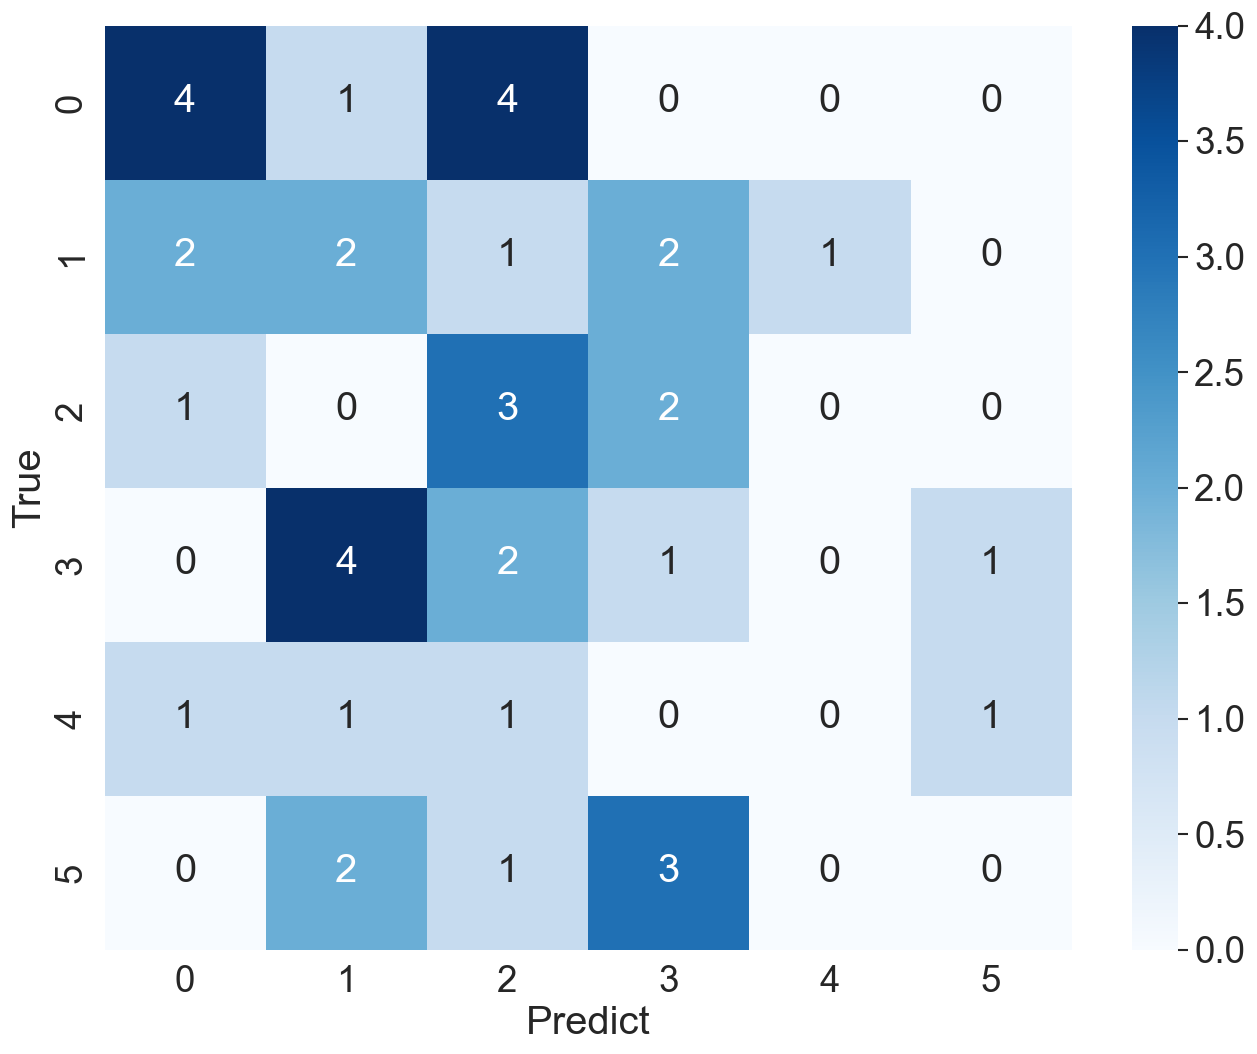

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(Y,PY)
sns.set(font_scale=1.5)
fig = plt.figure(figsize=(13, 10), dpi=120)
sns.heatmap(cm,annot=True, cmap='Blues')
plt.xlabel('Predict')
plt.ylabel('True')